In [3]:
cd ..

/Users/cchivers/proj/chime_sims


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pandas as pd
from os import getcwd, path

First run all hospitals projections holding out 7 days of data:
```bash
for loc in 'MCP' 'LGH' 'PAH' 'PMC' 'HUP' 'CCH' 'Downtown'; do python _01_GOF_sims.py -P $loc -C 4 -i 5000 --as_of 7 & done
```

Get the output directories from these runs:

In [132]:
hosps = ['Downtown', 'HUP', 'LGH', 'MCP', 'PAH', 'PMC', 'CCH']
date_str = '2020_04_16_12_06_03'
date_str = '2020_04_16_20_05_17' # use 'sample obs' flag
date_str = '2020_04_16_22_23_32' # remove vent residuals from likelihood func
date_str = '2020_04_17_00_14_13' # scale variance of ll
date_str = '2020_04_17_00_42_28' # log-normal loss function
date_str = '2020_04_17_01_05_00' # coefficient of variation
date_str = '2020_04_16_19_23_07' #
outdirs = [f"{date_str}_{hosp}" for hosp in hosps]

In [133]:
dfs = {}
tss = {}
for outdir in outdirs:
    print(outdir)
    dfs[outdir] = pd.read_json(path.join(f'output/{outdir}/output', 'chains.json.bz2'), orient='records', lines=True)
    tss[outdir] = pd.read_csv(path.join(f'output/{outdir}/parameters/census_ts.csv'))

2020_04_16_19_23_07_Downtown
2020_04_16_19_23_07_HUP
2020_04_16_19_23_07_LGH
2020_04_16_19_23_07_MCP
2020_04_16_19_23_07_PAH
2020_04_16_19_23_07_PMC
2020_04_16_19_23_07_CCH


In [134]:
as_of_days_ago = 7

In [135]:
q_hosp, q_vent = [], []

for outdir in outdirs:
    df = dfs[outdir]
    census_ts = tss[outdir]
    arrs = np.stack([df.arr.iloc[i] for i in range(df.shape[0])])
    print(outdir)
    for day in range(census_ts.shape[0] - as_of_days_ago, census_ts.shape[0]):
        q_hosp.append((arrs[:,day,3] > census_ts.hosp[day]).mean())
        q_vent.append((arrs[:,day,5] > census_ts.vent[day]).mean())

2020_04_16_19_23_07_Downtown
2020_04_16_19_23_07_HUP
2020_04_16_19_23_07_LGH
2020_04_16_19_23_07_MCP
2020_04_16_19_23_07_PAH
2020_04_16_19_23_07_PMC
2020_04_16_19_23_07_CCH


In [136]:
len(q_hosp)

49

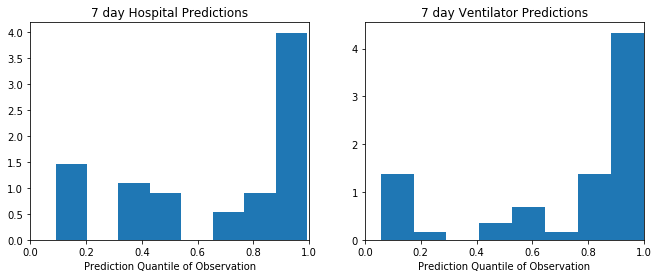

In [137]:
fig, ax = plt.subplots(1,2, figsize=(11,4))

for i, (obs_type,q_dist) in enumerate({'Hospital': q_hosp, 'Ventilator': q_vent}.items()):
    axx = ax[i]
    axx.hist(q_dist, density=True, bins=8)
    axx.set_xlim(0,1)
    axx.set_xlabel('Prediction Quantile of Observation')
    axx.set_title(f'{as_of_days_ago} day {obs_type} Predictions')

# Residuals

In [138]:
from scipy.stats import probplot

In [139]:
flatten = lambda l: [item for sublist in l for item in sublist]

2020_04_16_19_23_07_Downtown 33
2020_04_16_19_23_07_HUP 33
2020_04_16_19_23_07_LGH 23
2020_04_16_19_23_07_MCP 23
2020_04_16_19_23_07_PAH 20
2020_04_16_19_23_07_PMC 21
2020_04_16_19_23_07_CCH 23


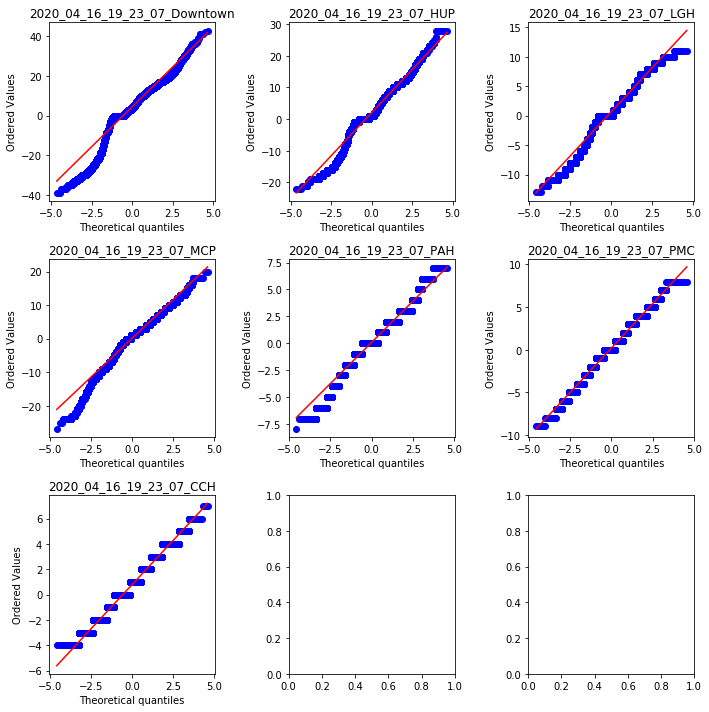

In [140]:
fig, axx = plt.subplots(3,3, figsize=(10,10))
for i, outdir in enumerate(outdirs):
    df = dfs[outdir]
    census_ts = tss[outdir]
    df = df.loc[(df.iter>1500)]
    arrs = np.stack([df.arr.iloc[i] for i in range(df.shape[0])])
    day = census_ts.shape[0] - as_of_days_ago
    print(outdir, day)
    residuals = [arrs[i,:day,3] - census_ts.hosp[:day] for i in range(arrs.shape[0])]
    res = flatten(residuals)
    
    ax = axx[i//3, i%3]
    probplot(res, dist="norm", plot=ax)
    ax.set_title(outdir)
fig.tight_layout()
plt.show()